<a href="https://colab.research.google.com/github/martinpius/PYTORCH/blob/main/Fitting_a_polynomial_with_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import matplotlib.pyplot as plt
  from torch import optim, nn
  import torch
  from torch.nn import L1Loss
  from torch.utils.data import Dataset, DataLoader
  from torchvision.transforms import transforms
  import time
  from sklearn.model_selection import train_test_split
  print(f">>>> You are on GoogLe colab with torch version: {torch.__version__}")

except Exception as e:
  COLAB = False
  print(f">>>> {type(e)}: {e}\n>>>> please correct {type(e)} and reload your drive")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n device: {device}")
!nvidia-smi

def __tmft__(t: float = 231.234)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h} mins: {m:>02} sec: {s:>5.2f}"

print(f">>>> testing the time formating function..........\n>>>> time elapsed\t{__tmft__()}")


Mounted at /content/drive/
>>>> You are on GoogLe colab with torch version: 1.12.1+cu113

 device: cuda
Mon Nov 21 21:35:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |    612MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------

In [50]:
# Creating a dummy data for a simple AI problem.
a, b, c, d = 0.3, 2.5, -0.89, 1.5
X = torch.randn(size = (100000,1)).reshape(-1,1)
Y = a + X*b + X*X*c + X*X*X*d


In [51]:
print(f">>>> X shape: {X.shape} Y shape: {Y.shape}")

>>>> X shape: torch.Size([100000, 1]) Y shape: torch.Size([100000, 1])


In [52]:
X[:3], Y[:3]

(tensor([[-0.8191],
         [ 0.7471],
         [-0.9417]]), tensor([[-3.1689],
         [ 2.2965],
         [-4.0964]]))

In [53]:
# Split the data into train, validation, and test set:

In [54]:
X_main, X_test, Y_main, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train, X_val, Y_train, Y_val = train_test_split(X_main, Y_main, test_size = 0.3)

In [55]:
print(f">>>> X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}\n\
 X_test shape: {X_test.shape},  Y_test shape: {Y_test.shape}\n\
X_val shape: {X_val.shape},  Y_val shape: {Y_val.shape}")

>>>> X_train shape: torch.Size([63000, 1]), Y_train shape: torch.Size([63000, 1])
 X_test shape: torch.Size([10000, 1]),  Y_test shape: torch.Size([10000, 1])
X_val shape: torch.Size([27000, 1]),  Y_val shape: torch.Size([27000, 1])


In [56]:
# Vizualize the train and test datasets:
def dfm_visualizer(X_train, Y_train, X_test, Y_test, predictions = None):
  plt.figure(figsize = (10, 8.5))
  plt.scatter(X_train, Y_train, s = 4, c = "b", label = "train")
  plt.scatter(X_test, Y_test, s = 4, c = "g", label = "test")
  if predictions is not None:
    plt.scatter(X_test, predictions, s = 4, c = "r", label = "predictions")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("model's performance vizualization")
  plt.legend()

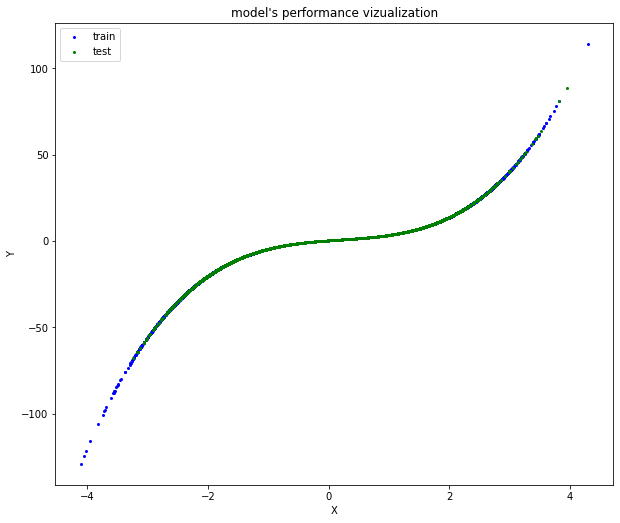

In [57]:
dfm_visualizer(X_train, Y_train, X_test, Y_test)

In [58]:
# Lets build a custom dataloader for SGD
class MyDataset(Dataset):
  def __init__(self, X, Y):
    super().__init__()
    self.X = X
    self.Y = Y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    X = self.X[idx]
    Y = self.Y[idx]
    return X, Y


In [59]:
train_data = MyDataset(X_train, Y_train)
train_loader = DataLoader(dataset = train_data, batch_size = 64, shuffle = True)
test_data = MyDataset(X_test, Y_test)
test_loader = DataLoader(dataset = test_data, batch_size = 64, shuffle = False)
val_data = MyDataset(X_val, Y_val)
val_loader = DataLoader(dataset = val_data, batch_size = 64, shuffle = True)

x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))
x_val, y_val = next(iter(val_loader))
print(f">>>> x_train batch: {x_train.shape}, y_train batch: {y_train.shape}\n>>>> \
x_test batch: {x_test.shape}, y_test batch: {y_test.shape}\n>>>> \
x_val batch: {x_val.shape}, y_val batch: {y_val.shape}")

>>>> x_train batch: torch.Size([64, 1]), y_train batch: torch.Size([64, 1])
>>>> x_test batch: torch.Size([64, 1]), y_test batch: torch.Size([64, 1])
>>>> x_val batch: torch.Size([64, 1]), y_val batch: torch.Size([64, 1])


In [60]:
# Lets build a Pytorch polynomial model to fit our data:{We know the data generation process}

In [61]:
class POLY(nn.Module):
  def __init__(self):
    super().__init__()
    self.a = nn.Parameter(torch.randn(1, dtype = torch.float, requires_grad = True))
    self.b = nn.Parameter(torch.randn(1, dtype = torch.float, requires_grad = True))
    self.c = nn.Parameter(torch.randn(1, dtype = torch.float, requires_grad = True))
    self.d = nn.Parameter(torch.randn(1, dtype = torch.float, requires_grad = True))
  
  def forward(self, X:torch.Tensor)->torch.Tensor:
    return self.a + X*self.b + X*X*self.c + X*X*X*self.d

In [62]:
# instantiating the model and produce the predictions for the untrained model:

In [63]:
poly = POLY()

In [64]:
with torch.inference_mode():
  preds = poly(X_test)

In [65]:
# print model's parameter
print(f">>> state_dictionary: {poly.state_dict()}")

>>> state_dictionary: OrderedDict([('a', tensor([-0.5296])), ('b', tensor([-1.9949])), ('c', tensor([-1.3879])), ('d', tensor([-0.3224]))])


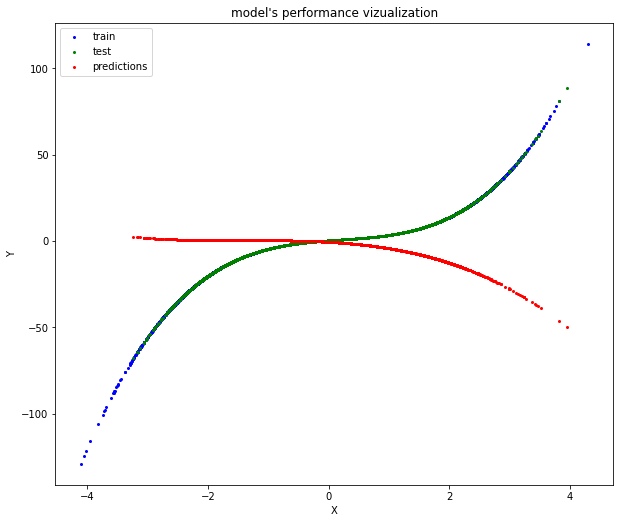

In [66]:
# Vizualize the predictions for the untrained model:
dfm_visualizer(X_train, Y_train, X_test, Y_test, predictions = preds)

In [67]:
# We need to train our model such that the red plot fit into the main plot as close as possible.

In [68]:
#Lets build a simple MLP to train on this data "Assume we dont have data generation distribution"
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.mlp = nn.Sequential(
        nn.Linear(in_features = self.input_dim, out_features = self.hidden_dim),
        nn.BatchNorm1d(num_features = self.hidden_dim),
        nn.ReLU(),
        nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim),
        nn.BatchNorm1d(self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, 1)
    )
  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.mlp(x)


In [69]:
# instantiating the neural net and produce predictions for untrained model
input_dim = 1
hidden_dim = 64
mlp = MLP(input_dim, hidden_dim)
input_tensor = torch.randn(size = (32,1))
assert mlp(input_tensor).shape == (32,1)

In [70]:
with torch.inference_mode():
  mlp_preds = mlp(X_test) 

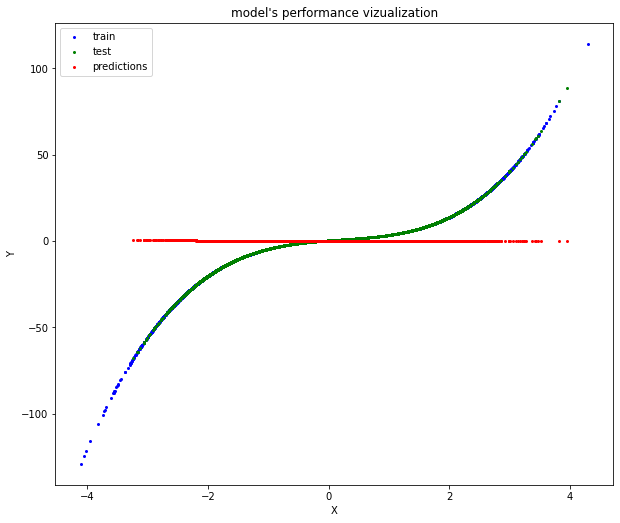

In [71]:
dfm_visualizer(X_train, Y_train, X_test, Y_test, predictions = mlp_preds.detach().numpy())

In [72]:
criterion = L1Loss()
learning_rate = 1e-3
optimizer1 = optim.SGD(params = poly.parameters(), lr = learning_rate)
optimizer2 = optim.SGD(params = mlp.parameters(), lr = learning_rate)

In [73]:
# The training loop:
def training_val_loop(model, optimizer, criterion, train_loader, val_loader,EPOCHS):
  print(f">>>> training start: please wait.....................")
  train_loss_per_epoch = 0
  val_loss_per_epoch = 0
  model.train()
  for epoch in range(EPOCHS):
    for batch, (data, labels) in enumerate(train_loader):
      data.to(device),labels.to(device)
      preds = model(data)
      optimizer.zero_grad()
      train_loss = criterion(preds, labels)
      train_loss.backward()
      optimizer.step()
      train_loss_per_epoch+=train_loss
    if epoch%10 == 0:
      print(f">>>> end of epoch: {epoch}, train loss: {train_loss_per_epoch/len(train_loader):.4f}")
      #print(f">>>> parameters: {model.state_dict()}")
    
    model.eval()
    for batch, (data, labels) in enumerate(val_loader):
      data.to(device), labels.to(device)
      preds = model(data)
      val_loss = criterion(preds, data)
      val_loss_per_epoch+=val_loss
    if epoch % 10 == 0:
      print(f">>>> end of epoch: {epoch}, validation loss: {val_loss_per_epoch/len(val_loader):.4f}")
      #print(f">>>> parameters: {model.state_dict()}")

def testing_loop(model, test_loader, criterion):
  print(f">>>> Testing the model using the test set.........")
  test_loss_per_batch = 0
  for batch_idx, (data, labels) in enumerate(test_loader):
    data.to(device), labels.to(device)
    preds = model(data)
    test_loss = criterion(preds, labels)
    test_loss_per_batch+=test_loss
  
  if batch_idx % 10 ==0:
    print(f">>>> Batch number: {batch_idx}: test_loss: {torch.mean(test_loss_per_batch):.4f}")
    #print(f">>>> parameters: {model.state_dict()}")



In [74]:
training_val_loop(poly, optimizer1, criterion, train_loader, val_loader, 100)

>>>> training start: please wait.....................
>>>> end of epoch: 0, train loss: 4.9591
>>>> end of epoch: 0, validation loss: 1.9588
>>>> end of epoch: 10, train loss: 12.4248
>>>> end of epoch: 10, validation loss: 34.7173
>>>> end of epoch: 20, train loss: 12.4396
>>>> end of epoch: 20, validation loss: 70.3363
>>>> end of epoch: 30, train loss: 12.4544
>>>> end of epoch: 30, validation loss: 105.9672
>>>> end of epoch: 40, train loss: 12.4692
>>>> end of epoch: 40, validation loss: 141.5964
>>>> end of epoch: 50, train loss: 12.4840
>>>> end of epoch: 50, validation loss: 177.2272
>>>> end of epoch: 60, train loss: 12.4988
>>>> end of epoch: 60, validation loss: 212.8561
>>>> end of epoch: 70, train loss: 12.5136
>>>> end of epoch: 70, validation loss: 248.4700
>>>> end of epoch: 80, train loss: 12.5285
>>>> end of epoch: 80, validation loss: 284.0909
>>>> end of epoch: 90, train loss: 12.5433
>>>> end of epoch: 90, validation loss: 319.7233


In [75]:
poly.eval()
with torch.inference_mode():
  my_predictions = poly(X_test)

In [76]:
# Lets plot the predictions for the trained polynomial.

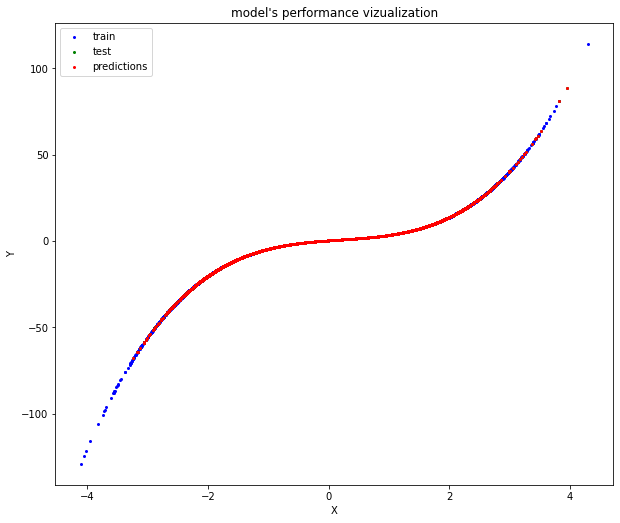

In [77]:
dfm_visualizer(X_train, Y_train, X_test, Y_test, predictions = my_predictions.detach().numpy())

In [78]:
# As seen in red, The trained model gave best predictions (The red plot (predictions) 
#perfectly overlap the observed <Y> test data.)

In [79]:
training_val_loop(mlp, optimizer2, criterion, train_loader, val_loader, 50)

>>>> training start: please wait.....................
>>>> end of epoch: 0, train loss: 1.8458
>>>> end of epoch: 0, validation loss: 2.9980
>>>> end of epoch: 10, train loss: 3.3632
>>>> end of epoch: 10, validation loss: 38.8127
>>>> end of epoch: 20, train loss: 4.1253
>>>> end of epoch: 20, validation loss: 74.3026
>>>> end of epoch: 30, train loss: 4.7104
>>>> end of epoch: 30, validation loss: 109.8951
>>>> end of epoch: 40, train loss: 5.2073
>>>> end of epoch: 40, validation loss: 145.6291


In [80]:
mlp.eval()
with torch.inference_mode():
  my_predictions1 = mlp(X_test)

In [ ]:
#Lets vizualize the prediction for the MLP

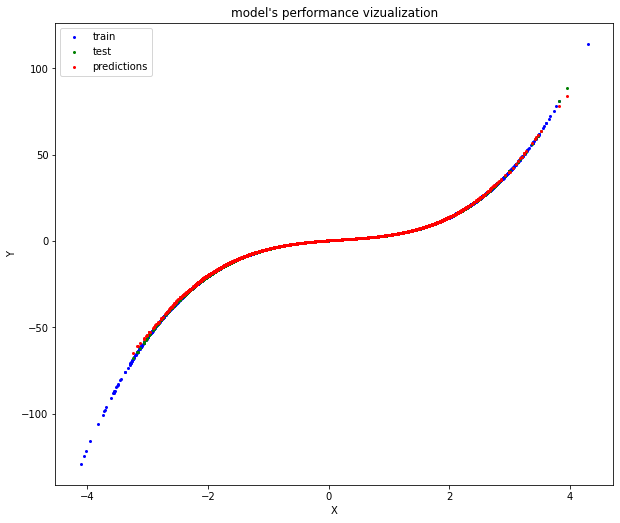

In [81]:
dfm_visualizer(X_train, Y_train, X_test, Y_test, predictions = my_predictions1.detach().numpy())